In [1]:
# Imports

import numpy as np
import sqlite3
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from pyts.image import GramianAngularField
import matplotlib.pyplot as plt

import pickle
import json

# Prepare data

In [3]:
# Import DataLoaders

trainloader1 = torch.load('trainloader.pth')
# validloader1 = torch.load('valloader.pth')
testloader1 = torch.load('testloader.pth')

# Model

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Select CNN structure - "novel" == novel, "original" == original
NN = "original" 

In [6]:
if NN == "novel":
    class Network(nn.Module):
        def __init__(self):
            super(Network, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=15, out_channels=32, kernel_size=3) 
            self.bn1 = nn.BatchNorm2d(32) 
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
            self.bn2 = nn.BatchNorm2d(32)
            self.pool = nn.MaxPool2d(2)
            self.drop1 = nn.Dropout(0.25) 
            # self.flat1 = nn.Flatten()
            self.fc1 = nn.Linear(2048, 32) 
            self.drop2 = nn.Dropout(0.5) 
            self.fc2 = nn.Linear(32, 1)

        def forward(self, input):
            output = F.relu(self.bn1(self.conv1(input)))      
            output = F.relu(self.bn2(self.conv2(output)))     
            output = self.pool(output)
            output = self.drop1(output) 
            output = output.flatten(1)                       
            output = F.relu(self.fc1(output)) 
            output = self.drop2(output) 
            output = self.fc2(output) 

            return output

if NN == "original":
    class Network(nn.Module):
        def __init__(self):
            super(Network, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=5, stride=1, padding=1) 
            self.bn1 = nn.BatchNorm2d(15) 
            self.conv2 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=5, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(15)
            self.pool = nn.MaxPool2d(2,2)
            self.drop1 = nn.Dropout(0.25)
            self.conv4 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=5, stride=1, padding=1)
            self.bn4 = nn.BatchNorm2d(15)
            self.conv5 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=5, stride=1, padding=1)
            self.bn5 = nn.BatchNorm2d(15)
            self.drop2 = nn.Dropout(0.5) 
            self.fc1 = nn.Linear(240, 1)

        def forward(self, input):
            output = F.relu(self.bn1(self.conv1(input)))      
            output = F.relu(self.bn2(self.conv2(output)))     
            output = self.pool(output)            
            output = self.drop1(output)             
            output = F.relu(self.bn4(self.conv4(output)))     
            output = F.relu(self.bn5(self.conv5(output)))
            output = output.flatten(1)
            output = self.drop2(output) 
            output = self.fc1(output)

            return output

# Instantiate a neural network model 
model = Network().to(device)
print( sum(p.numel() for p in model.parameters()))
print(model)

22921
Network(
  (conv1): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=240, out_features=1, bias=True)
)


In [7]:
learning_rate = 0.00005 # 0.5
criterion = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.0)

In [8]:
# Train

num_epochs = 500 # 5000

# %%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
min_valid_loss = 100000000
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in trainloader1:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in testloader1:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        # loss = torch.sqrt(criterion(output, target))
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)

        if valid_loss < min_valid_loss and epoch >= 5:
            min_valid_loss = valid_loss
            # torch.save(model.state_dict(), [redacted]]
    
    # calculate-average-losses
    train_loss = train_loss/len(trainloader1.sampler)
    valid_loss = valid_loss/len(testloader1.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.489278 	Validation Loss: 0.217458
Epoch: 2 	Training Loss: 0.441915 	Validation Loss: 0.222485
Epoch: 3 	Training Loss: 0.415544 	Validation Loss: 0.214127
Epoch: 4 	Training Loss: 0.408440 	Validation Loss: 0.260885
Epoch: 5 	Training Loss: 0.392304 	Validation Loss: 0.247286
Epoch: 6 	Training Loss: 0.355969 	Validation Loss: 0.269391
Epoch: 7 	Training Loss: 0.344272 	Validation Loss: 0.249983
Epoch: 8 	Training Loss: 0.332270 	Validation Loss: 0.257292
Epoch: 9 	Training Loss: 0.322955 	Validation Loss: 0.317343
Epoch: 10 	Training Loss: 0.309861 	Validation Loss: 0.281171
Epoch: 11 	Training Loss: 0.286922 	Validation Loss: 0.269100
Epoch: 12 	Training Loss: 0.290111 	Validation Loss: 0.323046
Epoch: 13 	Training Loss: 0.282222 	Validation Loss: 0.294370
Epoch: 14 	Training Loss: 0.258758 	Validation Loss: 0.330508
Epoch: 15 	Training Loss: 0.253824 	Validation Loss: 0.337888
Epoch: 16 	Training Loss: 0.236336 	Validation Loss: 0.289079
Epoch: 17 	Traini

KeyboardInterrupt: 

# Results

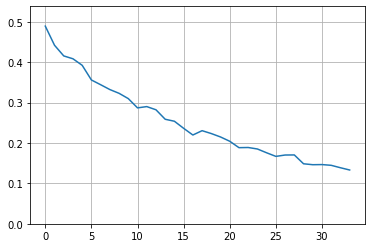

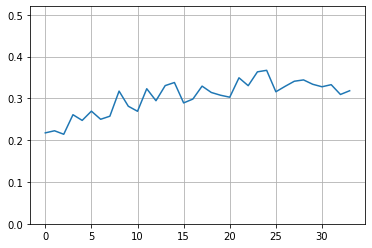

In [9]:
# Plot training and validation learning curves

fig, ax = plt.subplots()
ax.plot(train_losses)

ax.set(ylim=[0,(max(train_losses)*1.1)])
ax.grid()

plt.show()

fig, ax = plt.subplots()
ax.plot(valid_losses)

ax.set(ylim=[0,(max(valid_losses) + (max(valid_losses) - min(valid_losses)))])
ax.grid()

plt.show()

In [10]:
# load the best saved model 
# [redacted] model.load_state_dict(torch.load(

<All keys matched successfully>

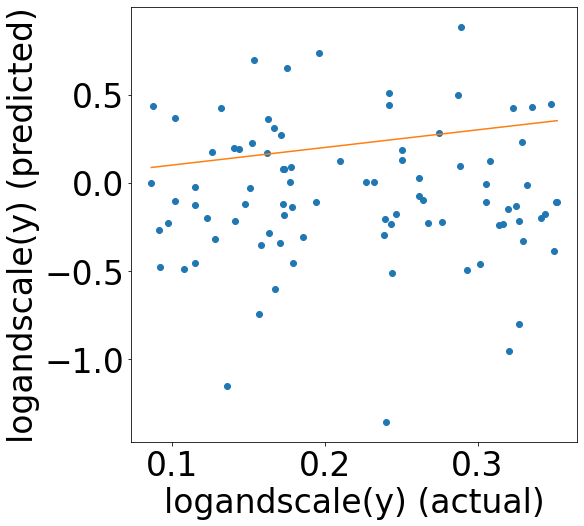

Mean relative error (original values):  0.9979768365506356


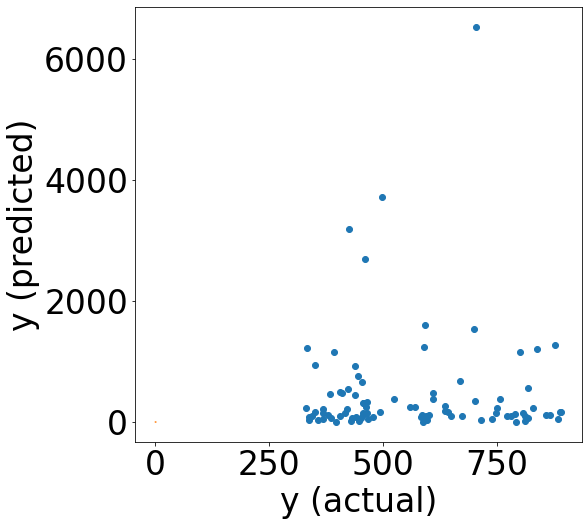

In [11]:
# Plot log & scaled predicted vs actual values

output_all = torch.empty(0)
target_all = torch.empty(0)

for data, target in testloader1:

    target = target.T[0]
    target_all = torch.cat( (target_all, target), 0)

    output = model(data)
    output = output.detach().T[0]
    output_all = torch.cat((output_all, output), 0)

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 33})

plt.plot(target_all, output_all, 'o' )
plt.xlabel("logandscale(y) (actual)")
plt.ylabel("logandscale(y) (predicted)");
max1 = target_all.max().item()
min1 = target_all.min().item()
plt.plot([min1,max1], [min1, max1])
plt.show()

# Plot untransformed predicted vs actual values

# Undo scaling and normalisation

with open("unscale.json", "r") as rf:
    unscale_factors = json.load(rf)

output_all_2 = output_all * unscale_factors[1]
target_all_2 = target_all * unscale_factors[1]
output_all_3 = output_all_2 + unscale_factors[0]
target_all_3 = target_all_2 + unscale_factors[0]
output_all_4 = torch.pow(10, output_all_3)
target_all_4 = torch.pow(10, target_all_3)

rel_error = torch.abs ( (output_all_4 - target_all_4) / target_all_4 )
mean_rel_error = rel_error.mean().item()
print("Mean relative error (original values): ", mean_rel_error)

plt.figure()
plt.plot(target_all_4, output_all_4, 'o' )
plt.xlabel("y (actual)")
plt.ylabel("y (predicted)");
max1 = target_all_2.max().item()
min1 = target_all_2.min().item()
plt.plot([min1, max1], [min1, max1])
plt.show()